<div align="center"><font size=10><b>Introduction to Artificial Neural Networks using the ADALINE model<b></font></div>

# Functions

In [4]:
#linear algebra
import numpy as np

#Symbolic calculation
from sympy import *

#Tables
import pandas as pd

#Graphics
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Interactive library
from ipywidgets import interact, fixed, interactive
import ipywidgets as widgets

# Display Equations
from IPython.display import display, HTML, Math, Latex


#Step function use for recall
def step(x):
    if x<0:
        return -1
    elif x>0:
        return 1
    else:
        return x
            
# vectorize the step function
outFunc=np.vectorize(step,otypes=[float])

#Learning 
def learn(inputs,targets,eta,minErr,maxEpochs):
    (nbPairs,dimIn)=np.shape(inputs) #number of pairs to learn and dimension of the Inputs
    dimOut=len(targets[1,:]) #dimension of the Outputs
    w=(np.random.random_sample((dimOut,dimIn))*2-1)*0.1 #random weight (-0.1,0.1)
    #w=np.zeros((dimOut,dimIn))
    mseList=[] #initialization of MSE list
    k=1
    stop=0
    #computation
    while stop<1: #computation of epochs
        randList = np.arange(nbPairs) 
        np.random.shuffle(randList) #random sample of randList            
        errorListEpoch=[] #empty list for the current epoch
        
        for i in range(0,nbPairs):
            
            choice=randList[i] #selection of a pairs
            x=np.reshape(inputs[choice,:],(dimIn,1)) #selection of a given input -> reshape in matrix
            t=np.reshape(targets[choice,:],(dimOut,1)) # corresponding target -> reshape in matrix              
            a=np.dot(w,x) #computation of the activation
            e=t-a #computation of the error
            w = w + eta * (np.dot(e,np.transpose(x))) #weights update
            errorListEpoch.append((np.dot(np.transpose(e),e)/dimOut)[0,0])
        

        k=k+1 #updating the number of epochs
        mseList.append(np.mean(errorListEpoch)) #mse computation and adding the result to the list
        
        if mseList[-1]<minErr or k>maxEpochs: #selection of the last element and compare it to error
            stop=1 #stop the while loop            
    
    return (w,mseList) #weights and MSE are returned    
    
    
#Recall    
def recall(inputs,targets,w): # fucntion (ex. step) can be passed like argument

    (nbPairs,dimIn)=np.shape(inputs)

    for i in range(0, nbPairs):
        x=np.reshape(inputs[i,:],(dimIn,1))
        a=np.dot(w,x) #computation of the activation
        y=step(a) 
        print(repr(np.ravel(x).tolist()).rjust(2), repr(np.ravel(y).tolist()).rjust(3))

#to illustrate the input as an image
def arrayPlot(images,divCol,size):
    (nbIm,dim)=images.shape
    fig = plt.figure(figsize=(size, size))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, nbIm),  # creates 1x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(-im.reshape([int(dim/divCol),divCol]),cmap='gray')
    plt.show() 
    
#explanation
def errFun(a):
    return ((1-a)**2)

#simple scatterplot 2d
def visual(inputs,targets,w,classLine):
    class1 = class2 = np.empty((0,inputs.shape[1]), float)
    
    for i in range(0, inputs.shape[0]):
        if targets[i]<0.5:
            class1=np.append(class1,np.array([inputs[i]]),axis=0)        
        else:
            class2=np.append(class2,np.array([inputs[i]]),axis=0)  

    # Create plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(class1[:,0],class1[:,1])
    ax.scatter(class2[:,0],class2[:,1])
    if classLine==1:
        dataLine=[(-w.flatten()[0]*-1-w.flatten()[2])/(w.flatten()[1]),(-w.flatten()[0]*1-w.flatten()[2])/(w.flatten()[1])]
        ax.plot([-1,1],dataLine)
    plt.xlabel('x1',fontsize=12)
    #plt.xlim([-1,1])
    plt.ylabel('x2',fontsize=12)
    #plt.ylim([-1,1])
    plt.show()

ModuleNotFoundError: No module named 'sympy'

# <b>From Natural to Artificial Neuron</b>

<img src="Neuron.png" width=600 />
<font size=4>The brain contains billions of neurons. Their role is to respond to stimuli from the environment, and transduce
these stimuli into electrical signals. Signals can then propagate (communicate) to other neurons and activate a motor response. 
    Moreover, neurons will not merely tranmsit the signals but they will process them.<br>
    Each neuron will have the signals transmit from the dendrite to axon terminals. At these locations it will connect to other neurons dendrite through the synapses. Signals that arrive at an axon terminal (presynaptic) will be converted into neurotransmitters (chemical molecules). These will then be captured by the dendtrites of the postsynaptic cell and converted into electrical current.<br>
    <ol>Two phenomena from the biological neuron are at core of (almost) any Artificial Neural Networks (ANN): 
        <li>Electric current will accumulate at the cell soma and  a nonlinear transmission function 
            will be used to propagated the signal to other neurons</li>
        <li>Signals are modified by the synapses.</li>
    </ol>
    In short, the artificial neuron can be seeing has having a linear accumulation (sum) with a nonlinear threshold.<br>
    In ANN we will use the following terminology that draw a rough parallel with biology.
    <ul><li>Unit = Neuron</li>
        <li>Input = Axon terminal signal (incoming signal)</li>
        <li>Output = Axon terminal signal (outgoing signal)</li>
        <li>Weight = Synapse</li>
    </ul>
<img src="AN.png" width=600 />
    <br>
    <br>
    Therefore, a single dendrite would be the equivalent of an input modified by its weight.<br>
    The activation is then the accumulation (summation) of the those modified inputs.<br>
    If the this accumulation reaches a threshold then the signal is propagate to the output.<br>
</font>

## Numerical Example of the Transmission

<font size=4>Let us say that in order for the unit <b>y</b><sub>1</sub> to send information (signal), it needs to reach a threshold 0.5 (or higher).<br>
    The units has 3 incoming inputs that has a value of <b>x</b>=[1,0,1] and corresponding weights of <b>W</b><sub>1</sub>
    =[0.2,-0.6, 0.4].<br>
    Weights can have positive (excitatory) or negative (inhibitory) values.<br>
    The activation (<b>a</b><sub>1</sub>) is computed as:<br><br>
    <b>a</b><sub>1</sub> = 1x0.2+0x-0.6+1x0.4 = 0.2+0+0.4 = 0.6<br>
    Since <b>a</b><sub>1</sub> (activation = 0.6) is greater or equal than 0.5, then <b>y</b><sub>1</sub> (output) 
    is set to 1 (signal).<br>
    <br>
    Now, if the inputs are <b>x</b>=[0,1,1], the activation will be:<br>
    <b>a</b><sub>1</sub> = 0x0.2+1x-0.6+1x0.4 = 0-0.6+0.4 = -0.2<br>
    Since <b>a</b><sub>1</sub> (activation = -0.2) is less than 0.5, then <b>y</b><sub>1</sub> (output) 
    is set to 0 (no signal).<br>
    <br>
    For any  $m$ incoming inputs for a given unit $j$, this process can be written as:<br>
    $\mathbf{y}_{j}=f(\mathbf{a}_{j})$ &emsp;&emsp;&emsp;&emsp; <i>non-linear</i> </pre><br>
    and<br> 
    $\mathbf{a}_{j}=\mathbf{W}_{j}\mathbf{x}_{1}+\mathbf{W}_{j}\mathbf{x}_{2}+...+\mathbf{W}_{j}\mathbf{x}_{i}+
    ...+\mathbf{W}_{j}\mathbf{x}_{m}$<br>
     $\mathbf{a}_{j}=\sum_{i=1}^{m}\mathbf{W}_{j}\mathbf{x}_{i}$ &emsp;&emsp; <i>linear</i><br>
     <br>
    Where $j$ is the given unit, $\mathbf{y}$ the output, $\mathbf{a}$ the activation, $f(\mathbf{a})$ the 
    threshold function,  $\mathbf{W}$ the weight, $\mathbf{x}$ the input and $m$ the number of inputs. 
    This is call the transmission function of the unit and can be written succinctly for all output units using linear algebra
    as :<br>
    $\mathbf{y}=f(\mathbf{Wx})$<br>

## Architecture

<font size=4>One unit is interesting, but a network of units is better as it will be able to perform more complex behaviours.<br>
    After humans have billions of neurons.<br>
    This generalization can is depicted as follow:<br>
    <img src="ANN.png" width=400 /><br>
    <br>
    Thus, inputs, <b>x</b> are distributed to all output units, <b>y</b>. If the values of the weights are different for each of these unit, then the output values may vary in function of the input. This will allow different generated behaviours using the same network. 
    
</font>

## Learning

<font size=4>In the previous example, the weights were set at a fixed value. However, akin to the biological neuron, it would be interesting that these weights adapt themselves in function of the task. In other words, if a unit is active (y=1) when it should not, then its weights should be decreased. Inversely, if the unit is not active (y=0) when it should, the weights should be increased. That is the role of the learning function.<br>
    One of the easiest learning function is Hebbian learning. This function borrowed from biology, states that 
    if a presynaptic current is present at the same time as postsynaptic current, then the synapse will be strengthened. <br>
    This can be written as :<br>
    $\mathbf{W}_{ji[k+1]}=\mathbf{W}_{ji[k]}+\eta \mathbf{y}_{j}\mathbf{x}_{i}$<br>
    where $\eta$ is small constant (ex. $\eta = 0.1$)<br>
    <br>
    For example, let us a say that a given weight $j$ has a value of 0.3 at time $k$=1 ($\mathbf{W}_{ji[1]}=0.3$) 
    and both input ($\mathbf{x}_{i}$) and output ($\mathbf{y}_{j}$) are active (=1). Then the weight 
    at time k=2 ($\mathbf{W}_{ji[2]}$) will be equal to :<br>
    $\mathbf{W}_{ji[2]}=$ 0.3+0.1x1x1 = 0.4<br>
    <br>
    If we repeat the process the weight will keep growing to infinity, which is not very plausible. <br>
    Therefore, correcting functions were proposed. One such example, is the ADALINE artificial neural network (next section).<br>
    <ul>To recap, an artificial will have three components:
        <li>A transmission function (how the information flows frome a unit to another)</li>
        <li>An architecture (how to units are connected together)</li>
        <li>A learning rule (how the weights are modified)</li>
    </ul>
    <b>Associationism</b><br>
    Associationism is one of the oldest, and, in some form or another, most widely held theories of thought. 
    Associationism has been the engine behind empiricism for centuries, from the British Empiricists through the Behaviorists
    and modern day Connectionists. Nevertheless, “associationism” does not refer to one particular theory of cognition per se,
    but rather a constellation of related though separable theses. What ties these theses together is a commitment to a certain
    rationality of thought: a creature’s mental states are associated because of some facts about its causal history,
    and having these mental states associated entails that bringing one of a pair of associates to mind will, ceteris
    paribus, ensure that the other also becomes activated."
    <a href="https://plato.stanford.edu/entries/associationist-thought/">Stanford Encyclopedia of Philosophy</a>
            
</font>

# <b>ADALINE<b>

<font size=4>The ADAptive LInear NEuron ou ADAptive LINear Element (ADALINE) is a supervised feedforward model proposed by Widrow and Hoff in 1960. Because the learning is linear it is simpler to understand how the weights change over time. In fact, the weights will be converging to the same solution as the one obtained from multiple regression.<br>The major difference being that the weights will reach the solution iteratively whereas in regression it is a one shot learning (through the pseudo-inverse).<br> 
<br>
B. Widrow and M. E. Hoff, “Adaptive Switching Circuits,” 1960 IRE WESCON Convention Record, 1960, pp. 96-104.

## Background</div>

<font size=4><b>Architecture</font></b>

<font size=4>The architecture is feedward.<br> We notice that the information (<b>x</b>) goes through the weights (<b>W</b>) to produce the output (<b>y</b>).<br>

<img src="Adaline.jpg" width=400 />

<font size=4><b>Transmission</font></b>

 <font size="3"> The transmission is divided in two: the activation and the output. <br>
    The activation is usually linear, while the output is nonlinear.<br>
    The activation is obtained by the summation of the product between the inputs (<b>x</b>) and the weights (<b>w</b>). <br>
    <br>
    $a_{1}=w_{11}x_{1}+w_{12}x_{2}+...+w_{1m}x_{m}$<br>
    $a_{2}=w_{21}x_{1}+w_{22}x_{2}+...+w_{2m}x_{m}$<br>
    ...<br>
    $a_{n}=w_{n1}x_{1}+w_{n2}x_{2}+...+w_{nm}x_{m}$<br>
    <br>or linear algebra notation:<br><br>
    $\mathbf{a}=\mathbf{Wx}$<br>
    <br>
    The <u>activation</u> (<b>a</b>) is based on the matrix product between the input and the weights.<br>
The nonlinearity comes from the <u>output</u> that uses a step function:<br><br>
    $\mathbf{y}_{i} =\begin{cases}1 & \text{if }\mathbf{a}_{i}>0\\-1 & \text{if }\mathbf{a}_{i}<0 \\ 0 &  \text{if }\mathbf{a}_{i}=0  \end{cases}$<br>
    <br>This function allows the network to output the closest class (decision).<br>
To some extend, it allows the network to filter noise
</font>

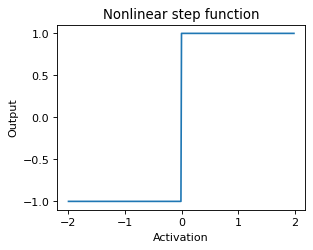

In [11]:
#graph
a = np.arange(-2.0, 2.0, 0.01)
s = outFunc(a)
fig, ax = plt.subplots(figsize=(4, 3), dpi=80)
ax.plot(a, s)
ax.set(xlabel='Activation', ylabel='Output')
plt.title('Nonlinear step function')
plt.show()

<font size=4><b>Learning</font></b>

<font size="4">$\mathbf{W}_{[k+1]}= \mathbf{W}_{[k]} + \Delta \mathbf{W}_{[k]}$<br>
    <br>
$\Rightarrow \mathbf{W}_{[k+1]}= \mathbf{W}_{[k]} + \eta (\mathbf{t}-\mathbf{a})\mathbf{x}^\text{T}$<br>
    <br>The weights are modified according to the difference between the desired behaviour (<b>t</b>) and the activation (<b>a</b>).<br>
In this particular model, the <i>learning</i> is based on the activation while the <i>recall</i>  is based on the transmission (activation + step).<br>The learning will reach convergence when the activation matches the target. If <b>t</b>-<b>a</b> = 0, then <b>W</b> at time <i>k</i>+1 will be equal to <b>W</b> at time <i>k</i> + 0.<br>
    The learning can be illustrated for single neuron ($y_{1}$) by the following<br>
    <br>
    <img src="Neuron-learning.png" width=500 />
    <br>
    Optional math :) The idea is to minimize the squared error <b>e</b><sup>2</sup>=(<b>t</b>-<b>a</b>)<sup>2</sup> in function of the weights (<b>w</b>). <br>
    This function can be described by the following figure when <b>t</b>=1 and <b>x</b>=1; remember <b>a</b>=<b>Wx</b>
    
    

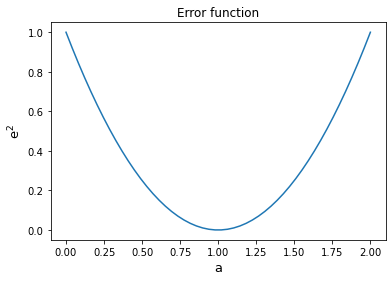

In [15]:
a = np.linspace(0, 2, 50)

# Figure
fig, ax = plt.subplots()
ax.plot(a, errFun(a))
plt.title('Error function')
ax.set_xlabel('$\mathregular{a}$', fontsize = 13)
ax.set_ylabel('$\mathregular{e}^2$', fontsize = 13)
plt.show()

<font size=4>From the figure, we can see that the minimum will be obtained when <b>a</b> will also have a value of one.
    Since <b>x</b>=1, this can be only achieved when the weight <b>W</b> is also equal to 1. However, if the learning starts at any values other than 1, how do we know how to update <b>W</b> to be closer to 1?<br>
    
<font size=4>If we look at the slope at a given value of <b>a</b> we could go in the direction that points toward the minimum error (gradient). 
    In other words, we need to look at the derivative of the function.

<font size=4>
Using linear algebra, the error is thus defined by: <b>e</b><sup>2</sup>=(<b>t</b>-<b>a</b>)(<b>t</b>-<b>a</b>)<sup>T</sup>=(<b>t</b>-<b>Wx</b>)(<b>t</b>-<b>Wx</b>)<sup>T<br>

<font size=4>And the derivative will equal to<br>
$ \dfrac{\delta \mathbf{e}^2}{\delta \mathbf{w}^\text{T}}=-2\mathbf{tx}^\text{T}+2\mathbf{Wxx}^\text{T}$<br><br>
This function maximizes the error. To minimize it, we must go in the opposite direction (gradient)<br>
$ \dfrac{\delta \mathbf{e}^2}{\delta \mathbf{w}^\text{T}}=-(-2\mathbf{tx}^\text{T}+2\mathbf{Wxx}^\text{T})$<br><br>
$ \dfrac{\delta \mathbf{e}^2}{\delta \mathbf{w}^\text{T}}=2(\mathbf{tx}^\text{T}-\mathbf{Wxx}^\text{T})$<br><br>
Finally, if we replace the constant "2" by a small learning parameter $\eta$ and <b>Wx</b> by <b>a</b> we obtain the following update function<br>
$ \Delta\mathbf{W}_{[k]}=\eta(\mathbf{t}-\mathbf{a})\mathbf{x}^\text{T}$<br>

    
    

## Numerical Example

<font size=4>
    We will do a simple task of associating the input pattern <b>x</b> = [1,-1], 
    with the desired output of <b>t</b> = [1]

In [2]:
eta=0.15                #Learning paramter

x=np.array([[1],[-1]])  # Input pattern.
t=np.array([[1]])       # Desired output.
w=np.zeros((1,2))       # The connections are initialized at zero.
time=0                  # Initiatlization of the time index (learning trial)
errorList=[]            # Creating an empty list to track the error.

<font size=4>
    <i>Each time the next cell is activated the network will perform one learning trial

In [3]:
print('Weights at Time =',time)
print(w)
print()
print('Activation =')
a=np.dot(w,x)
print(a)
print()
print('Error =')
e=t-a
errorList.append(e[0,0])
print(e)
print()
print('New Weights at Time',time+1)
w=w+eta*np.dot(t-a,np.transpose(x))
time+=1
print(w)
print()

axeXticks=[]
for i in range(1,len(errorList)+1):
    axeXticks.append(i)

fig, ax = plt.subplots(figsize=(4,2))
ax.plot(axeXticks, errorList)
ax.set_xlabel('$Learning  Trial$', fontsize = 13)
ax.set_ylabel('$Error$', fontsize = 13)
ax.set(title='$\eta=$'+str(eta))
plt.ylim([0, 1.1])
plt.show()

Weights at Time = 0
[[0. 0.]]

Activation =
[[0.]]

Error =
[[1.]]

New Weights at Time 1
[[ 0.15 -0.15]]



<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
C:\Users\domin\AppData\Local\Temp\ipykernel_7820\1874035009.py:27: SyntaxWarning: invalid escape sequence '\e'
  ax.set(title='$\eta=$'+str(eta))
C:\Users\domin\AppData\Local\Temp\ipykernel_7820\1874035009.py:27: SyntaxWarning: invalid escape sequence '\e'
  ax.set(title='$\eta=$'+str(eta))


NameError: name 'plt' is not defined

<font size=4>The learning parameter, <i>&#951;</i>, (eta) plays a role on the time (learning trials) it will takes for the network to learn the task.<br>
    The following graph illustrates various scenario obtained by manipulating this learning parameter ($\eta$)

    

<font size=4><b>Learning parameter at the right value

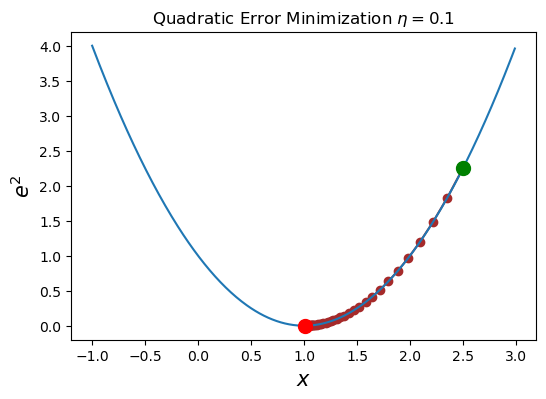

In [20]:
##############
# Parameters #
##############
eta=0.1 #eta; step
w0=w=2.5 #Weights initialization


###############
# Computation #
###############

#List initialization
list=np.empty((0,2), int)

#Iterating for the next 50 values
for _ in range(50):
    list=np.append(list,np.array([[w,errFun(w)]]),axis=0)
    nw=w+eta*(1-(w*1))
    w=nw

#figure
a = np.arange(-1.0, 3.0, 0.01)
s = errFun(a)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list[:,0],list[:,1],'o-',c='brown',zorder=1) #middle
ax.scatter(list[-1,0],errFun(list[-1,0]),c='red',s=100,zorder=3) #end
ax.scatter(w0,errFun(w0),c='green',s=100,zorder=3) #begin
ax.plot(a, s)
ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$e^2$', fontsize = 15)
ax.set(title='Quadratic Error Minimization '+'$\eta=$'+str(eta))
plt.show()

<font size=4><b>Learning parameter too low

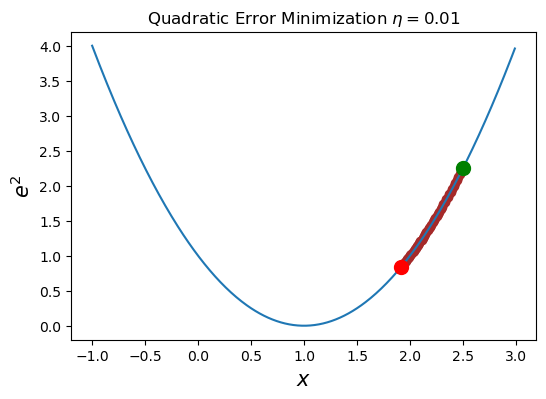

In [21]:
##############
# Parameters #
##############
eta=0.01 #eta; step
w0=w=2.5 #Weights initialization


###############
# Computation #
###############

#List initialization
list=np.empty((0,2), int)

#Iterating for the next 50 values
for _ in range(50):
    list=np.append(list,np.array([[w,errFun(w)]]),axis=0)
    nw=w+eta*(1-(w*1))
    w=nw

#figure
a = np.arange(-1.0, 3.0, 0.01)
s = errFun(a)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list[:,0],list[:,1],'o-',c='brown',zorder=1) #middle
ax.scatter(list[-1,0],errFun(list[-1,0]),c='red',s=100,zorder=3) #end
ax.scatter(w0,errFun(w0),c='green',s=100,zorder=3) #begin
ax.plot(a, s)
ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$e^2$', fontsize = 15)
ax.set(title='Quadratic Error Minimization '+'$\eta=$'+str(eta))
plt.show()

<font size=4><b>Learning parameter too high

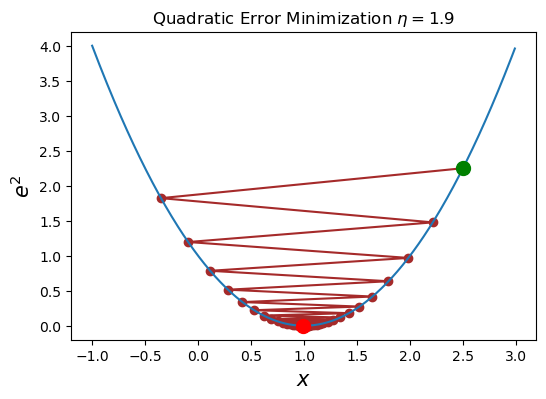

In [22]:
##############
# Parameters #
##############
eta=1.9 #eta; step
w0=w=2.5 #Weights initialization


###############
# Computation #
###############

#List initialization
list=np.empty((0,2), int)

#Iterating for the next 50 values
for _ in range(50):
    list=np.append(list,np.array([[w,errFun(w)]]),axis=0)
    nw=w+eta*(1-(w*1))
    w=nw

#figure
a = np.arange(-1.0, 3.0, 0.01)
s = errFun(a)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list[:,0],list[:,1],'o-',c='brown',zorder=1) #middle
ax.scatter(list[-1,0],errFun(list[-1,0]),c='red',s=100,zorder=3) #end
ax.scatter(w0,errFun(w0),c='green',s=100,zorder=3) #begin
ax.plot(a, s)
ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$e^2$', fontsize = 15)
ax.set(title='Quadratic Error Minimization '+'$\eta=$'+str(eta))
plt.show()

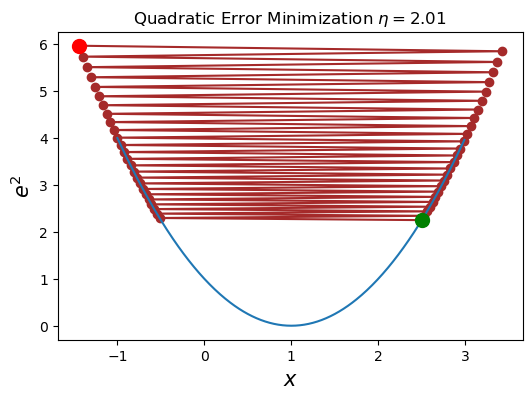

In [23]:
##############
# Parameters #
##############
eta=2.01 #eta; step
w0=w=2.5 #Weights initialization


###############
# Computation #
###############

#List initialization
list=np.empty((0,2), int)

#Iterating for the next 50 values
for _ in range(50):
    list=np.append(list,np.array([[w,errFun(w)]]),axis=0)
    nw=w+eta*(1-(w*1))
    w=nw

#figure
a = np.arange(-1.0, 3.0, 0.01)
s = errFun(a)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list[:,0],list[:,1],'o-',c='brown',zorder=1) #middle
ax.scatter(list[-1,0],errFun(list[-1,0]),c='red',s=100,zorder=3) #end
ax.scatter(w0,errFun(w0),c='green',s=100,zorder=3) #begin
ax.plot(a, s)
ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$e^2$', fontsize = 15)
ax.set(title='Quadratic Error Minimization '+'$\eta=$'+str(eta))
plt.show()

<font size=4>
    If the learning parameter is too high, the network can oscillate around the solution or even grow out of bound.<br>
    If it is too low, the network will not have enough trials to find the optimal solution.<br>
    A rule of thumbs is to set it according : $\eta = 1/N$.<br>
    Where $N$ is the dimension of the input.
    

# Simulation

## Task 1: T-C

<font size=4>This example consist to classify the T and C whatever their orientation.<br>The input patterns are bipolar symbols that can be illustrated by a grid where a black pixel has the value of 1 and a white pixel a value of -1.

<font size=5><b>Inputs</b></font>

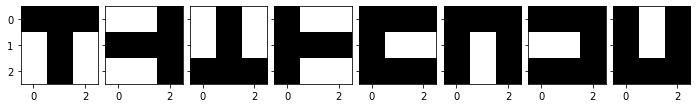

In [4]:
#Task; can be modified
inputs=np.array([[1,1,1,-1,1,-1,-1,1,-1],[-1,-1,1,1,1,1,-1,-1,1],[-1,1,-1,-1,1,-1,1,1,1],
                 [1,-1,-1,1,1,1,1,-1,-1],[1,1,1,1,-1,-1,1,1,1],[1,1,1,1,-1,1,1,-1,1],
                 [1,1,1,-1,-1,1,1,1,1],[1,-1,1,1,-1,1,1,1,1]])

#figure
divColIn=3 #Vector partition after a given number of columns
sizeIn=12  #Size of the figure
arrayPlot(inputs,divColIn,sizeIn)

<font size=5><b>Targets</b></font>

<font size=4>The desired outputs (targets) are also bipolar symbols.
The dimension of the output determine the number of units(neurons) in the network.
In this case there are two neurons that receive nine connections (inputs) each. 

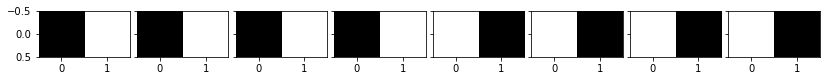

In [5]:
targets=np.array([[1,-1],[1,-1],[1,-1],[1,-1],[-1,1],[-1,1],[-1,1],[-1,1]])

#figure
divColTar=2 #Vector partition after a given number of columns
sizeTar=14  #Size of the figure
arrayPlot(targets,divColTar,sizeTar)

<font size=5><b>Learning</b></font>

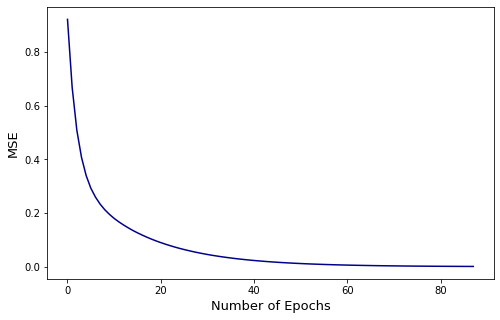

In [13]:
#Parameters
eta=0.01           # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=1000      # maximum learning trials (epochs) to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
plt.show()

<font size=5><b>Recall: No noise</b></font>

Inputs


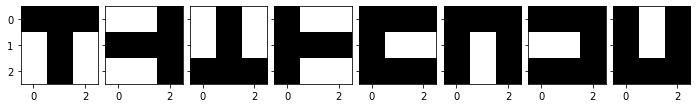

Outputs


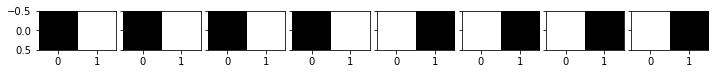

In [14]:
#figure
print('Inputs')
arrayPlot(inputs,divColIn,sizeIn)

#Computation of the outputs
outputsList=[]
for i in range(len(inputs)):
    y=outFunc(np.dot(w,inputs[i]))
    outputsList.append(y)
    
#figure
print('Outputs')
arrayPlot(np.array(outputsList),divColTar,12)

<font size=5><b>Recall: Noise</b></font>

<font size=4>Noisy input

Original pattern


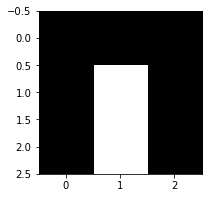

noise level =  11.11 %


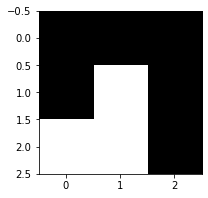

Obtained output


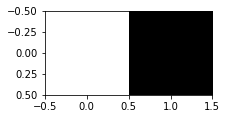

Correct recall


In [15]:
noise=1 # nb of random pixels flipped
choice=5 # selected pattern

print('Original pattern')
x0=np.reshape(inputs[choice,:],(len(inputs[0]),1)) #selection of a given input -> reshape in matrix
arrayPlot(x0.reshape(1,np.shape(w)[1]),divColIn,3)

xtest=x0.copy()
randList = np.arange(len(x0)) 

np.random.shuffle(randList) #random sample of randList   
for i in range(0,noise):
    if xtest[randList[i]]>0.5:
        xtest[randList[i]]=-1.0
    else:
        xtest[randList[i]]=1.0

x=xtest.copy()

print('noise level = ',round(noise/len(x0)*10000.)/100,'%')
arrayPlot(x.reshape(1,np.shape(w)[1]),divColIn,3)


print('Obtained output')
y=outFunc(np.dot(w,x))

#graph
arrayPlot(y.reshape(1,np.shape(w)[0]),divColTar,3)

if np.dot(np.transpose(y),targets[choice])/len(y)==1:
    print('Correct recall')
else:
    print('Wrong recall')

Obtained output

## Task 2: Order

<font size=4>The task consists to associate lower-case letters to their corresponding symbolic codies called 1-hot encoding.<br>
The letters are placed on a 7x7 grid, therefore they give vectors of 49 dimensions.

<font size=5><b>Inputs</b></font>

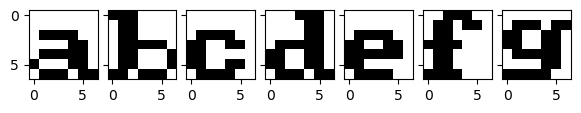

In [25]:
# Lower-case inputs
nbPat=7                              #number of patterns to learn [1-26]
patterns=np.genfromtxt('alpMin.dat')  #inputs are read from file
inputs = patterns[0:nbPat, :]


#figure
divColIn=7 #Vector partition after a given number of columns
sizeIn=nbPat  #Size of the figure
arrayPlot(inputs,divColIn,sizeIn)

<font size=5><b>Targets</b></font>

<font size=4>The targets are simple symbols where the position of a black pixel denotes the corresponding position of a given letter.

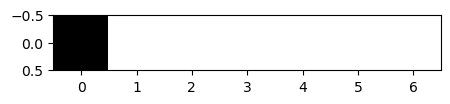

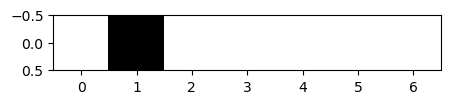

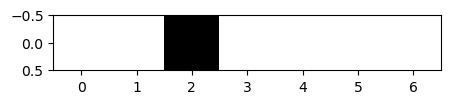

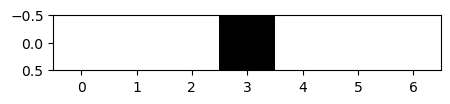

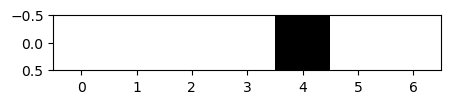

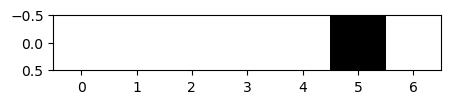

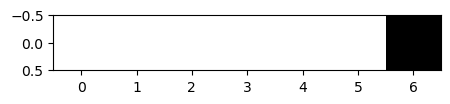

In [1092]:
#figure are generated in function of the number of inputs
targets=np.identity(nbPat)*2-1
for i in range(nbPat):
    arrayPlot(np.array([targets[i]]),nbPat,5)

<font size=5><b>Learning</b></font>

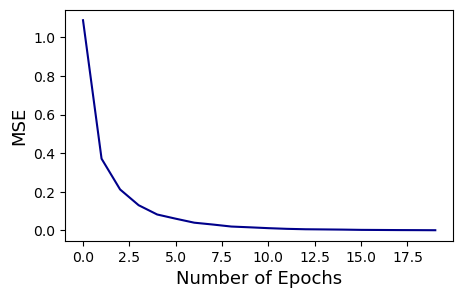

In [1096]:
#Parameters
eta=0.01          # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=500      # maximum learning trials to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
plt.show()

<font size=5><b>Recall: No noise</b></font>

Inputs


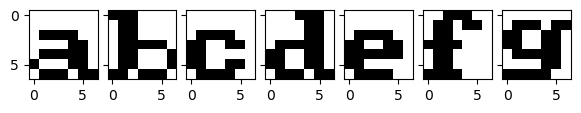

Outputs


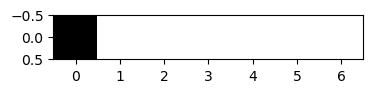

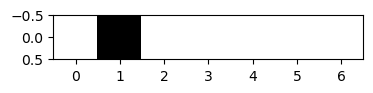

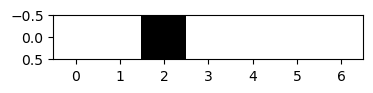

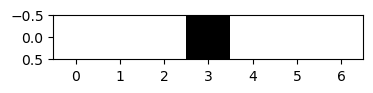

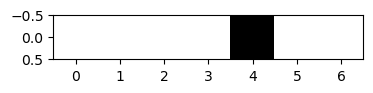

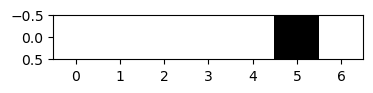

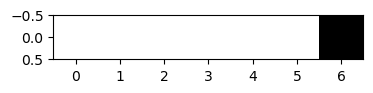

In [1098]:
#figure
print('Inputs')
arrayPlot(inputs,divColIn,sizeIn)

#Computation of the outputs
outputsList=[]
for i in range(len(inputs)):
    y=outFunc(np.dot(w,inputs[i]))
    outputsList.append(y)

print('Outputs')    
#figure
for i in range(nbPat):
    arrayPlot(np.array([outputsList[i]]),nbPat,4)

<font size=5><b>Recall: Noise</b></font>

<font size=4>Noisy input

Original pattern


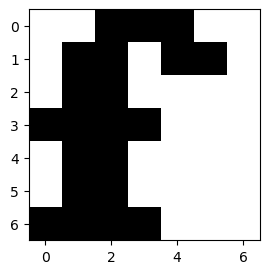

Noise level =  6.12 %


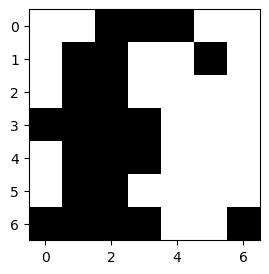

Obtained Output


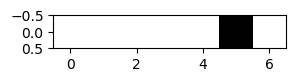

Correct recall


In [1099]:
noise=3  # nb of random pixels flipped
choice=5 # selected pattern

x0=np.reshape(inputs[choice,:],(len(inputs[0]),1)) #selection of a given input -> reshape in matrix
print('Original pattern')
arrayPlot(x0.reshape(1,np.shape(w)[1]),divColIn,3)

xtest=x0.copy()
randList = np.arange(len(x0)) 

np.random.shuffle(randList) #random sample of randList   
for i in range(0,noise):
    if xtest[randList[i]]>0.5:
        xtest[randList[i]]=-1.0
    else:
        xtest[randList[i]]=1.0

x=xtest.copy()

print('Noise level = ',round(noise/len(x0)*10000.)/100,'%')
arrayPlot(x.reshape(1,np.shape(w)[1]),divColIn,3)

print('Obtained Output')
y=outFunc(np.dot(w,x))

#graph
arrayPlot(y.reshape(1,np.shape(w)[0]),nbPat,3)
# automatic evaluation
if np.dot(np.transpose(y),targets[choice])/len(y)==1:
    print('Correct recall')
else:
    print('Wrong recall')

## Task 3: One-to-one association

<font size =4>The task consists to associate lower-case letters to their corresponding upper-case letters

<font size=5><b>Inputs</b></font>

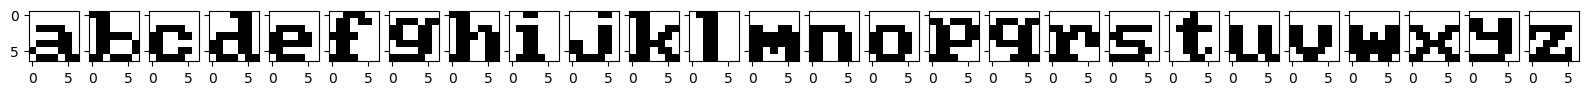

In [1100]:
# Lower-case inputs
inputs=np.genfromtxt('alpMin.dat')
divColIn=7
sizeIn=20

#figure
arrayPlot(inputs,divColIn,sizeIn)

<font size=5><b>Targets</b></font>

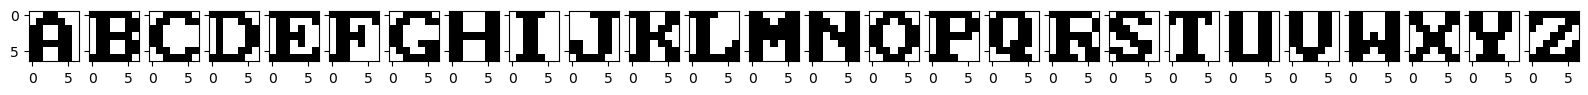

In [1101]:
# Upper-case inputs
targets=np.genfromtxt('alpMaj.dat')
divColTar=7
sizeTar=20

#figure
arrayPlot(targets,divColTar,sizeTar)

<font size=5><b>Learning</b></font>

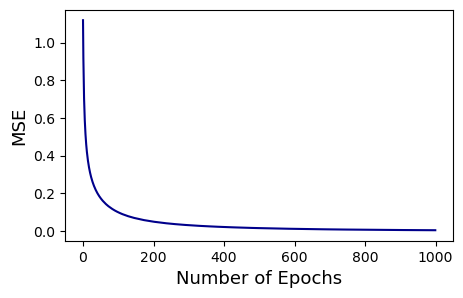

In [1103]:
#Parameters
eta=0.001          # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=1000      # maximum learning trials to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
plt.show()

<font size=5><b>Recall: No noise</b></font>

Inputs


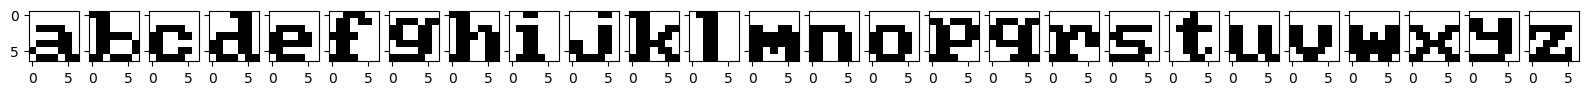

Outputs


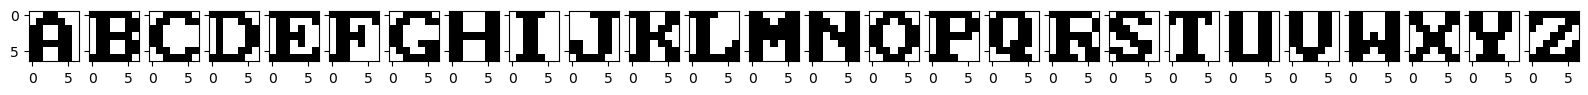

In [1104]:
#figure
print('Inputs')
arrayPlot(inputs,divColIn,sizeIn)

#Computation of the outputs
outputsList=[]
for i in range(len(inputs)):
    y=outFunc(np.dot(w,inputs[i]))
    outputsList.append(y)

print('Outputs')    
#figure
arrayPlot(np.array(outputsList),divColTar,sizeTar)

<font size=5><b>Recall: Noise</b></font>

<font size=4>Noise input

Original pattern


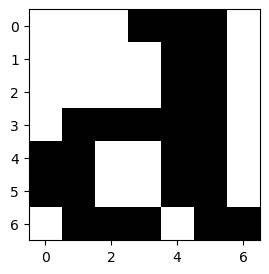

noise level =  10.2 %


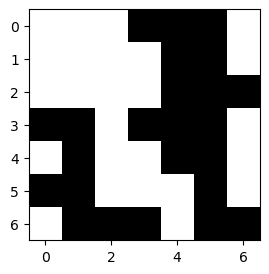

Obtained Output


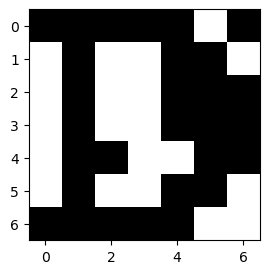

Wrong recall


In [1105]:
noise=5 # nb of random pixels flipped
choice=3 # selected pattern

x0=np.reshape(inputs[choice,:],(len(inputs[0]),1)) #selection of a given input -> reshape in matrix
xtest=x0.copy()

print('Original pattern')
arrayPlot(x0.reshape(1,np.shape(w)[1]),divColIn,3)

#random pixels flipped
randList = np.arange(len(x0)) 
np.random.shuffle(randList) #random sample of randList   
for i in range(0,noise):
    if xtest[randList[i]]>0.5:
        xtest[randList[i]]=-1.0
    else:
        xtest[randList[i]]=1.0
x=xtest.copy()

print('noise level = ',round(noise/len(x0)*10000.)/100,'%')
arrayPlot(x.reshape(1,np.shape(w)[1]),divColIn,3)

print('Obtained Output')
y=outFunc(np.dot(w,x))

#graph
arrayPlot(y.reshape(1,np.shape(w)[0]),divColTar,3)


if np.dot(np.transpose(y),targets[choice])/len(y)==1:
    print('Correct recall')
else:
    print('Wrong recall')


## Task 4: Boolean Functions

### AND Function

<font size=5><b>Inputs and Targets</b></font>

,x1,x2,t
Pairs 1,1,1,1
Pairs 2,1,0,0
Pairs 3,0,1,0
Pairs 4,0,0,0


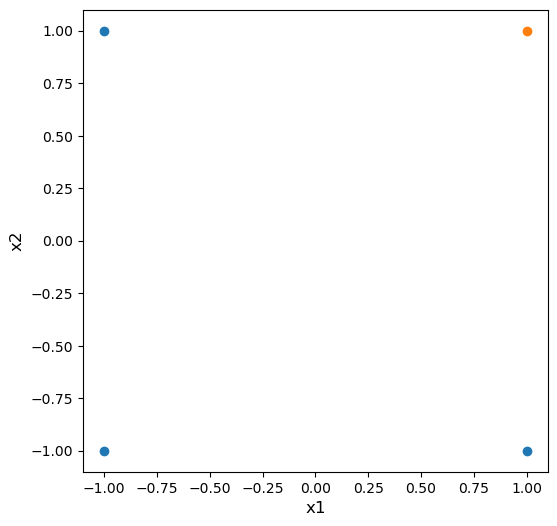

In [1106]:
inputsInit=np.array([[1,1],[1,0],[0,1],[0,0]])
targetsInit=np.array([[1],[0],[0],[0]])
df=pd.DataFrame(np.concatenate((inputsInit,targetsInit),axis=1),columns=['x1','x2','t'],
                index=['Pairs 1','Pairs 2','Pairs 3','Pairs 4'])
display(df)

#Rescale the pattern between [-1,1] + bias to the inputs
inputs=np.concatenate((inputsInit*2-1,np.ones((len(inputsInit),1))),axis=1)
targets=targetsInit*2-1
visual(inputsInit*2-1,targetsInit,0,0)

<font size=5><b>Learning</b></font>

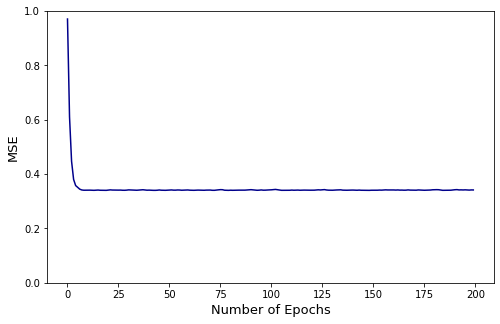

In [218]:
#Parameters
eta=0.1          # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=200      # maximum learning trials to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
ax.set_ylim(0,1)
plt.show()

<font size=5><b>Recall</b></font>

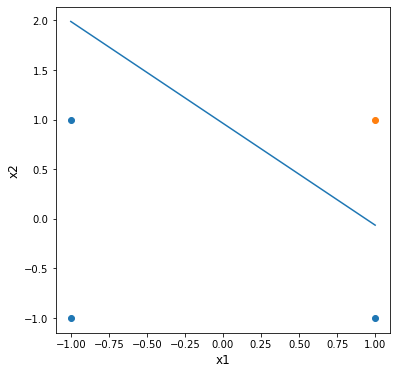

In [219]:
visual(inputs,targetsInit,w,1)

### XOR Function

<font size=5><b>Inputs and Targets</b></font>

,x1,x2,t
Pairs 1,1,1,1
Pairs 2,1,0,0
Pairs 3,0,1,0
Pairs 4,0,0,1


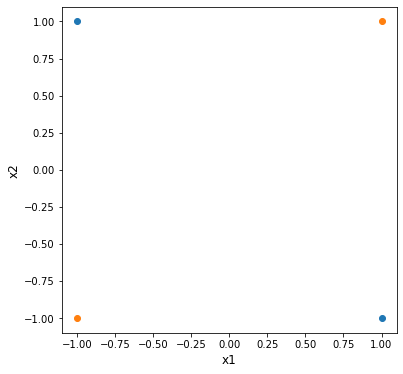

In [221]:
inputsInit=np.array([[1,1],[1,0],[0,1],[0,0]])
targetsInit=np.array([[1],[0],[0],[1]])
df=pd.DataFrame(np.concatenate((inputsInit,targetsInit),axis=1),columns=['x1','x2','t'],
                index=['Pairs 1','Pairs 2','Pairs 3','Pairs 4'])
display(df)

#Rescale the pattern between [-1,1] + bias to the inputs
inputs=np.concatenate((inputsInit*2-1,np.ones((len(inputsInit),1))),axis=1)
targets=targetsInit*2-1
visual(inputsInit*2-1,targetsInit,0,0)

<font size=5><b>Learning</b></font>

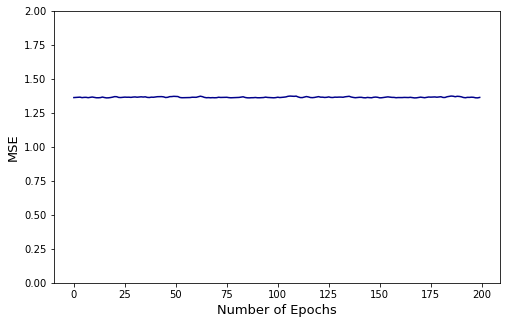

In [224]:
#Parameters
eta=0.1          # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=200      # maximum learning trials to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
ax.set_ylim(0,2)
plt.show()

<font size=5><b>Recall</b></font>

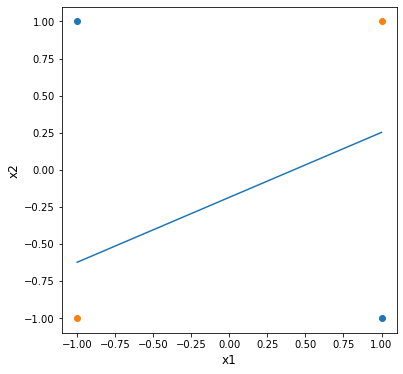

In [225]:
visual(inputs,targetsInit,w,1)

## Task 5: Nonlinear Classification

<font size=5><b>Inputs (coordinates) and Targets (colours)</b></font>

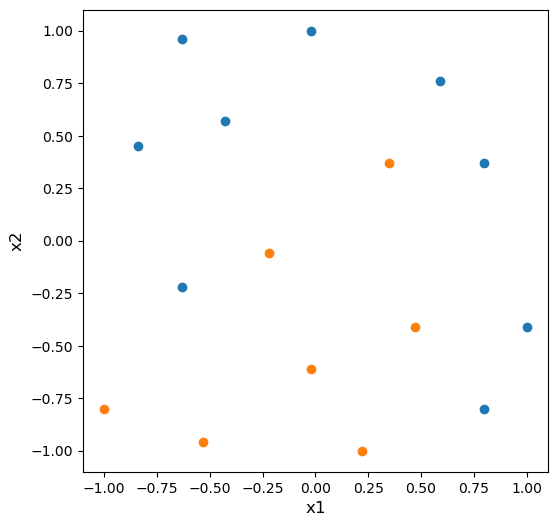

In [24]:
inputs=np.loadtxt('inputsNoise.csv', delimiter=',')
targets=np.transpose([np.loadtxt('targetsNoise.csv', delimiter=',')])
visual(inputs,targets,0,0)
inputs=np.concatenate((inputs,np.ones((len(inputs),1))),axis=1)

<font size=5><b>Learning</b></font>

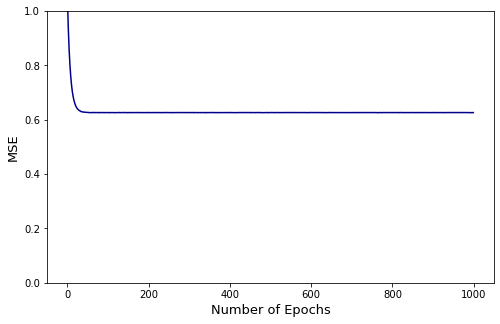

In [212]:
#Parameters
eta=0.01          # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=1000      # maximum learning trials to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
ax.set_ylim(0,1)
plt.show()

<font size=5><b>Recall</b></font>

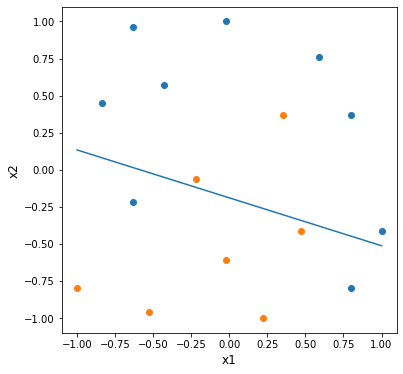

In [213]:
visual(inputs,targets,w,1)

<font size=4>The Adaline can only find a linear separation between the classes

## Task 6: Linear Regression

<font size=4>Usually, the learning is linear and the recall nonlinear. However, if we use a linear <i>recall</i>  and learning, then the ADALINE can perform linear regression just like standard classical analysis. 

<font size=4><b>Inputs and Targets

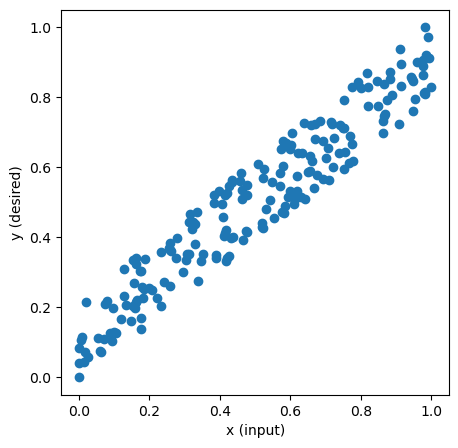

In [12]:
xList=[]
yList=[]
for _ in range(200):
    x=np.random.rand()*3-1
    y=3*x+np.random.rand()*2.5
    xList.append(x)
    yList.append(y)
    
inputsX=(xList-np.min(xList))/np.max(xList-np.min(xList))
targets=np.transpose([(yList-np.min(yList))/np.max(yList-np.min(yList))])
# graph
fig = plt.figure(figsize=(5.,5.))
plt.scatter(inputsX,targets)
plt.xlabel("x (input)")
plt.ylabel("y (desired)")
plt.show()
inputs=np.c_[inputsX,np.ones(len(inputsX))]
#inputsY=np.c_[inputsY,np.ones(len(inputsY))]

<font size=4><b>Learning

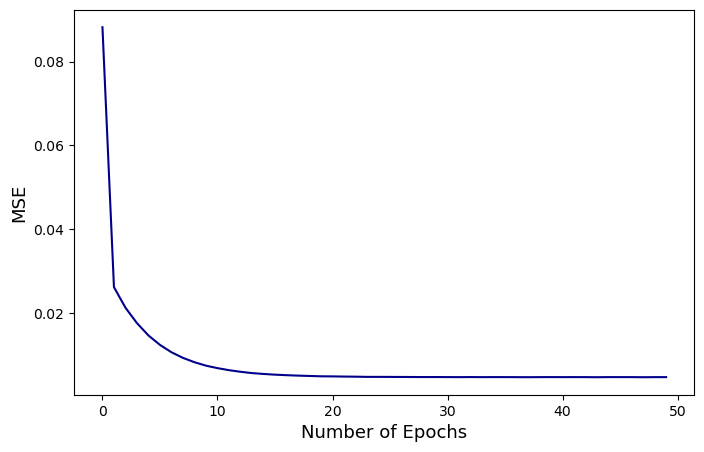

In [16]:
#Parameters
eta=0.01           # learning parameter
minError=10**-3    # minimum error to reach to stop the simulation; Mean Squared Error
maxEpochs=50      # maximum learning trials (epochs) to stop the simulation; in case the learning does not converges. 


#simulation 
(w,mseList)=learn(inputs,targets,eta,minError,maxEpochs)    

#figure MSE 
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
plt.show()

<font size=4><b>Recall

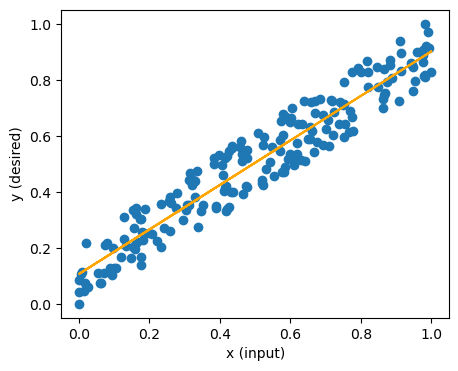

In [24]:
outputsList=[]
for i in range(len(inputs)):
    y=np.dot(w,inputs[i])
    outputsList.append(y)
outputsList=np.array(outputsList)

fig = plt.figure(figsize=(5.,4.))
plt.scatter(inputsX,targets)
plt.plot(inputsX,outputsList,color='orange')
plt.xlabel("x (input)")
plt.ylabel("y (desired)")
plt.show()

<font size=4><b>Statistical analysis</b>
    <br>
    If we perform standard linear regression we will get the same equation.<br>
    $b_{1}=\frac{s_y}{s_x}r_{xy}$<br>
    and<br>
    $b_{0}=\overline{y}-b_{1}\overline{x}$<br>
    In other words, the ADALINE performs linear regression in a more natural setting, not all the data are available at once. 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[[0.795 0.106]]


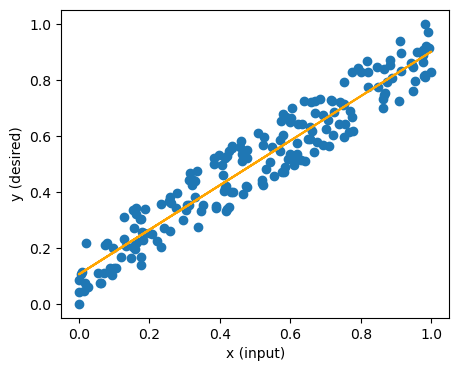

In [26]:
sx=np.std(inputsX,ddof=1)                          # Standard Deviation for x (sample)
sy=np.std(targets,ddof=1)                          # Standard Deviation for y (sample)
rxy=np.corrcoef(inputsX,targets.flatten())[0,1]    # Correlation 
b1=sy/sx*rxy                                       # b1
b0=np.mean(targets)-b1*np.mean(inputsX)            # b0

display(HTML('<font size=4 color="DarkBlue">Standard deviations</font>'))
display(HTML('<font color="Black">s<sub>x</sub> = '+str(np.round(sx,3))))
display(HTML('<font color="Black"><font color="Black">s<sub>y</sub> = '+str(np.round(sy,3))))
display(HTML('<font size=4 color="DarkBlue">Correlation</font>'))
display(HTML('<font color="Black">r<sub>xy</sub> = '+str(np.round(rxy,3))))
display(HTML('<font size=4 color="DarkBlue">Regression equation'))
display(Latex('$\widehat{y}=b_{0}+b_{1}x$'))
display(Latex('$\widehat{y}=$'+str(np.round(b0,3))+'+'+str(np.round(b1,3))+'$x$'))
display(HTML('<font size=4 color="DarkBlue">Weights from the ADALINE'))
print(np.round(w,3))

yp=b1*np.array(inputsX)+b0
fig = plt.figure(figsize=(5.,4.))
plt.scatter(inputsX,targets)
plt.plot(inputsX,yp,color='orange')
plt.xlabel("x (input)")
plt.ylabel("y (desired)")
plt.show()



# Some Observations

<font size=4><ul>
    The model can be used in different types of tasks.<br>
    <li>For example, task 1, 2, 3 and 5 represent cases for classification.</li>
    <li>Task 1 and 5 are called a many-to-one situation where several inputs lead to the same output.</li>
    <li>In contrast, task 2 and 3 are called one-to-one situation where for every input there is only one possible output.</li>
    <li>They way the targets are encoded has an impact on performance.<br>
        For example, in Task 3 an one-hot encoding was used; only one units is one for a given pattern.<br>
        While for Task 4 it was a distributed encoding in similar fashion as the inputs.<br>
        One-hot yield much better performance under noise compared to the distributed one.<br>
        However, for modelling cognitive processes, the later is closer to reality (maybe).<br>
        Results are the reason dynamical system were developped (BSB, Hopfield, BAM)</li>
    <li>If the network is in a many-to-one situation (task 4,  5 and 6), then the network will perform linear regression.<br>
        While task 4 -AND was successfully separated by the ADALINE, it was not the case for task 4 -XOR.<br>
        Because the ADALINE tried to fit a line, it is therefore limited 
        to linear classification/regression as shown in tasks 5 and 6.</li>
    <li>One final remark, just like the majority of supervised model, the teacher signal ($\mathbf{t}$) 
        is outside the network. This is not biologicaly plausible; see section 3.1</li>

# Implementation

<font size=4>We will implement the learning function using task 1.

First we need to decide the value of the learning parameter <i>&eta;</i>,
minimum mean squared error and maximum number of learning trials (epochs)

In [1042]:
eta=0.1 #value of learning parameter
minErr=10**-5 # minimum MSE for stopping the learning
maxEpochs=500 # maximum number of epochs for stopping the learning

Then we need to activate inputs and targets

In [1043]:
inputs=np.array([[1,1,1,-1,1,-1,-1,1,-1],[-1,-1,1,1,1,1,-1,-1,1],[-1,1,-1,-1,1,-1,1,1,1],
                 [1,-1,-1,1,1,1,1,-1,-1],[1,1,1,1,-1,-1,1,1,1],[1,1,1,1,-1,1,1,-1,1],
                 [1,1,1,-1,-1,1,1,1,1],[1,-1,1,1,-1,1,1,1,1]])

targets=np.array([[1,-1],[1,-1],[1,-1],[1,-1],[-1,1],[-1,1],[-1,1],[-1,1]])



We can then define the number of units in function of the dimensionality of the inputs and targets.
The function <b>np.shape()</b> return the dimensionality of a matrix

In [1044]:
np.shape(inputs)

(8, 9)

We can seen that 8 represents the number of patterns (pairs inputs-targets) and 9 the size of an input.
We can assign these info to their corresponding variables

In [1045]:
(nbPairs,dimIn)=np.shape(inputs)

Now if we take a look at the dimensionality of the targets we 

In [1046]:
np.shape(targets)

(8, 2)

We see that the size of the target is 2. Therefore the network will have 2 units (size of the targets) with 9 connections (size of the inputs) each

Another way to get the size of the targets is to select one target and compute the number of elements (<b>len()</b>)

In [1047]:
targets[0,:] # first target is selected

array([ 1, -1])

In [1048]:
len(targets[0,:])

2

Again we can assign that value to a variable

In [1049]:
dimOut=len(targets[0,:])

Now we can define the weight matrix that will allow the mapping of the input to the output.
This matrix will contain all the connections. 
These connections are initialized at random using an uniform distribution (<b>np.random.random_sample()</b>)

In [1050]:
np.random.random_sample() # each time this cell is selected a new random number is generated

0.789117157468835

We will need 9x2 random connections

In [1051]:
np.random.random_sample((dimOut,dimIn))

array([[0.09484238, 0.11967263, 0.14754881, 0.5720877 , 0.13776517,
        0.4146726 , 0.81943635, 0.51142892, 0.07976447],
       [0.24535312, 0.58815215, 0.31413662, 0.36674614, 0.05655026,
        0.58013537, 0.66371637, 0.83266021, 0.31307678]])

These connection are all between 0 and 1. However, we want those connections to be small around 0.
Therefore we will<br> 
1- multiply every values by 2. The distribution will now be between 0 and 2.<br>
2- substract 1 to every values. The distibution will now be between -1 and 1.<br>
3- multiply every values by 0.1. The final distribution will thus be between -0.1 and 0.1

In [1052]:
 w=(np.random.random_sample((dimOut,dimIn))*2-1)*0.1 #random weights (-0.1,0.1)

Next we want to select at random pair of input-target then do the learning. <br>
We want to repeat the process until all pairs have been presented. <br>
Then we will reshuffle and repeat the process. <br>
This is called sampling without replacement and it is equal to one epoch learning. <br>
The first step is to create a list will the position of all pairs (<b>np.arange()</b>)

In [1053]:
np.arange(nbPairs) 

array([0, 1, 2, 3, 4, 5, 6, 7])

Again we assign the result into a variable

In [1054]:
randList=np.arange(nbPairs) 

Next we need to shuffle the elements of this list (<b>np.random.shuffle()</b>)

In [1055]:
np.random.shuffle(randList) #each time we activate this cell, the list will be shuffled
randList

array([2, 4, 0, 3, 6, 5, 7, 1])

We are almost ready to do the first learning. <br>But before we will create an empty list to gather information about mean squared error of the current epoch

In [1056]:
errorListEpoch=[]

Now we can select the first pair using randList

In [1057]:
choice=randList[0] #we start with the first pair (Python starts at 0)

We select the input

In [1058]:
inputs[choice,:]

array([-1,  1, -1, -1,  1, -1,  1,  1,  1])

However this input is not in the proper form. <br>
We want it to be a matrix of 9 rows and 1 column.<br>
It is easier to use matrix notation to match mathematical equation and code.<br>
We will use the function <b>np.reshape()</b>  and assign the result to the variable x

In [1059]:
x=np.reshape(inputs[choice,:],(dimIn,1)) #selection of a given input -> reshape in matrix
x

array([[-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1]])

We will repeat the process for the target, t

In [1060]:
t=np.reshape(targets[choice,:],(dimOut,1)) # corresponding target -> reshape in matrix    
t

array([[ 1],
       [-1]])

We are now ready to compute the activation (a=Wx).<br>
This is done using matrix multiplication (<b>np.dot()</b>)

In [1061]:
a=np.dot(w,x) #computation of the activation
a

array([[-0.15895666],
       [-0.17486673]])

Now we can compare this activation with the target. <br>
Any discrepancy is the error (e) that we want to reduce.

In [1062]:
e=t-a #computation of the error
e

array([[ 1.15895666],
       [-0.82513327]])

We are now ready to compute the weights update using the adaline learning rule.<br>
It is a matrix multiplication between the error (e=t-x) and the transpose of the input x

In [1063]:
eta * (np.dot(e,np.transpose(x)))

array([[-0.11589567,  0.11589567, -0.11589567, -0.11589567,  0.11589567,
        -0.11589567,  0.11589567,  0.11589567,  0.11589567],
       [ 0.08251333, -0.08251333,  0.08251333,  0.08251333, -0.08251333,
         0.08251333, -0.08251333, -0.08251333, -0.08251333]])

We can add these changes to the old weights to obtain the new ones

In [1064]:
w = w + eta * (np.dot(e,np.transpose(x))) #weights update
w

array([[-0.09720517,  0.13368898, -0.03757666, -0.15185923,  0.08393003,
        -0.09541534,  0.12613915,  0.06517404,  0.09311573],
       [ 0.07277668, -0.11438277,  0.09612926,  0.11694567,  0.0109316 ,
         0.14033297, -0.11738693, -0.09956624, -0.17089775]])

Finally, we need to compute the MSE in order to see if the network learns correctly.<br>
The first step is to compute the squared error. 

In [1065]:
np.dot(np.transpose(e),e)

array([[2.02402546]])

Then if we devide this error by the dimensionality of the output we will get the mean squared error

In [1066]:
(np.dot(np.transpose(e),e)/dimOut)[0,0]

1.0120127295628993

We can thus append this MSE to errorListEpoch

In [1067]:
errorListEpoch.append((np.dot(np.transpose(e),e)/dimOut)[0,0])
errorListEpoch

[1.0120127295628993]

We are now ready to redo the learning for the second pair. <br>
In order to speed up the process we will use the <b>for</b> function.<br>
Since there are 8 pairs, we want to iterate throught the list starting at 0 up to 7.
We will get something like: <br>

<b>for i in range(nbPairs)</b><br>

If we put everything together we will get



In [1068]:
errorListEpoch=[]

for i in range(0,nbPairs):
            
    choice=randList[i] #selection of a pairs
    x=np.reshape(inputs[choice,:],(dimIn,1)) #selection of a given input -> reshape in matrix
    t=np.reshape(targets[choice,:],(dimOut,1)) # corresponding target -> reshape in matrix              
    a=np.dot(w,x) #computation of the activation
    e=t-a #computation of the error
    w = w + eta * (np.dot(e,np.transpose(x))) #weights update
    errorListEpoch.append((np.dot(np.transpose(e),e)/dimOut)[0,0])
    
errorListEpoch

[0.010120127295628981,
 1.6130424606568508,
 1.0646390361718594,
 1.9877534281745666,
 0.12045081231372917,
 0.022495953698913336,
 0.02633448258780474,
 1.163010645324691]

Then we will create an empty list to gather information about the mean squared error. 

In [1069]:
mseList=[]

We want the network to learn until this MSE is very low or if the maximum the number of learning trial has been reach.<br>
Therfore we will use the <b>while</b> function

First we need to set the initial condition of the function.<br>
We will use a variable <b>k</b> to keep track of the learning trials.<br>
We will also use the variable <b>stop</b>, to stop the learning if the MSE is low enough. 

In [1070]:
k=1      #first learning trial
stop=0   #0 means do not stop and 1 means stop

We will then repeat the previous for loop for a given epoch.<br>
Once that for loop is completed we will need to update <b>k</b>,<br>
compute the mean (<b>np.mean()</b>) of the MSE for all patterns <br> 
and update the <b>mseList</b>.

In [1071]:
k=k+1 #updating the number of epochs
k

2

In [1072]:
mseList.append(np.mean(errorListEpoch)) #mse computation and adding the result to the list
mseList

[0.7509808682780055]

Finally, we need to check the condition for stopping the <b>for</b> loop. <br>
We will use the <b>if</b> function.<br>

1- If the last element of the mean squared error list (<b>mseList[-1]</b>) is lower than the desired minumum error (<b>minErr</b>),<br> then the learning should stop (<b>stop=1</b>).

<b> if mseList[-1]<minErr:<br>
&nbsp;&nbsp;&nbsp;&nbsp;stop=1 <br>
    

2- If the number of epochs (<b>k</b>) has reached the desired maximum number (<b>maxEpochs</b>), <br>
    Then the learning should stop as well (<b>stop=1</b>).
    
<b> if k>=maxEpochs:<br>
&nbsp;&nbsp;&nbsp;&nbsp;stop=1 </b><br>   
    
Both conditions can be included within a single <b>if</b> by using <b>or</b>

In [1073]:
if mseList[-1]<minErr or k>maxEpochs: #selection of the last element and compare it to error
    stop=1 #stop the while loop  

Now the only thing remaining is putting everything together within a function.<br>
We will define the function <b>learn</b> where the parameters will be:<br>
inputs, targets, eta, minErr and maxEpochs.<br>
And we want the function to return the MSE list (<b>mseList</b>) and the final weights (<b>w</b>)


In [1074]:
#Learning 
def learn(inputs,targets,eta,minErr,maxEpochs):
    (nbPairs,dimIn)=np.shape(inputs) #number of pairs to learn and dimension of the Inputs
    dimOut=len(targets[1,:]) #dimension of the Outputs
    w=(np.random.random_sample((dimOut,dimIn))*2-1)*0.1 #random weight (-0.1,0.1)
    #w=np.zeros((dimOut,dimIn))
    mseList=[] #initialization of MSE list
    k=1
    stop=0
    #computation
    while stop<1: #computation of epochs
        randList = np.arange(nbPairs) 
        np.random.shuffle(randList) #random sample of randList            
        errorListEpoch=[] #empty list for the current epoch
        
        for i in range(0,nbPairs):
            
            choice=randList[i] #selection of a pairs
            x=np.reshape(inputs[choice,:],(dimIn,1)) #selection of a given input -> reshape in matrix
            t=np.reshape(targets[choice,:],(dimOut,1)) # corresponding target -> reshape in matrix              
            a=np.dot(w,x) #computation of the activation
            e=t-a #computation of the error
            w = w + eta * (np.dot(e,np.transpose(x))) #weights update
            errorListEpoch.append((np.dot(np.transpose(e),e)/dimOut)[0,0])
        

        k=k+1 #updating the number of epochs
        mseList.append(np.mean(errorListEpoch)) #mse computation and adding the result to the list
        
        if mseList[-1]<minErr or k>maxEpochs: #selection of the last element and compare it to error
            stop=1 #stop the while loop            
    
    return (w,mseList) #weights and MSE are returned    
    
    

We can then call this function to perform the learning

In [1075]:
eta=0.01
minErr=10**-7
maxEpochs=20

(w,mseList)=learn(inputs,targets,eta,minErr,maxEpochs)
print('w =',w)
print()
print('MSE List =',mseList)

w = [[-0.12993975 -0.01979191 -0.08018827 -0.03912279  0.56118186 -0.02621365
  -0.10549256 -0.04349988 -0.13695304]
 [ 0.09767387  0.01406954  0.12293063  0.00795108 -0.56077671  0.05484591
   0.13077592  0.0476003   0.10463246]]

MSE List = [1.0023169227111672, 0.7345039410599777, 0.5672578663072305, 0.4598723307977536, 0.3878637153404376, 0.3376291422932901, 0.3004479174574458, 0.2724587332096887, 0.2492934367449332, 0.22970107712082175, 0.2125295191768191, 0.19731301771127618, 0.18335427572939195, 0.17129966234279914, 0.15984572128439622, 0.14924169887251806, 0.1393805949586194, 0.13016647840892676, 0.1214649253697922, 0.11359767605531146]


Using the weights we can then test the network by creating a recall function. <br>
And with the MSE List we can plot it to have a graph of error vs number of epochs. <br>

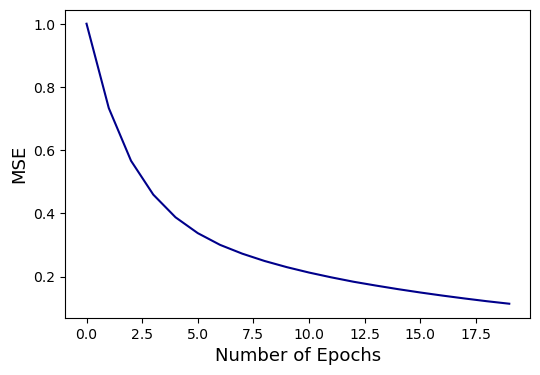

In [1084]:
# Graph 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(mseList,color='darkblue',linewidth=1.5)
ax.set_xlabel('Number of Epochs', fontsize = 13)
ax.set_ylabel('MSE', fontsize = 13)
plt.show()